In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import os
import numpy as np
import copy
import json
import cv2
from tqdm import tqdm
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

import IPython
from IPython.display import Image as img
from IPython.display import display

from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F

In [4]:
from src.datamodules.datasets.emoreccom import EmoRecComDataset
from src.models.bert_classifier_model import BertClassifierLitModel
from src.datamodules.datasets.dataset_modality import DatasetModality
from src.datamodules.emoreccom_datamodule import EmoRecComDataModule
from src.utils.text.text_utils import merge_comic_texts
from src.utils.text.goemotions_utils import goemotions_emotion_list, emoreccom_goemotions_emotion_mapping
from src.utils.metric.micro_auc import compute_micro_auc
from src.utils.emoreccom_label_transforms import normalize_and_take_top_n

In [6]:
label_transform = normalize_and_take_top_n

In [7]:
emoreccom_path = "/home/gsoykan20/Desktop/datasets/multimodal_emotion_recognition_on_comics_scenes/"#"/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
dataset = EmoRecComDataset(emoreccom_path, train=True, label_transform=None)

In [8]:
len(dataset)

6112

angry 		 --> 0.0 | 0.0
disgust 	 --> 0.0 | 0.0
fear 		 --> 0.0 | 0.0
happy 		 --> 1.0 | 0.167
sad 		 --> 1.0 | 0.167
surprise 	 --> 0.0 | 0.0
neutral 	 --> 1.0 | 0.333
other 		 --> 0.0 | 0.0

### Dialogs:
--> loune ! it worked ! it worked !
--> i dont understand did you give her the powder ?

### Narratives:
--> afewminutes later




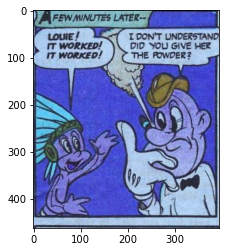

In [13]:
img, sizes, (labels, polarities), (narrative, dialog) = dataset.__getitem__(np.random.randint(dataset.__len__()))

for emotion, value, polarity in zip(dataset.emotion_list, labels, polarities):
    print(emotion, "\t\t" if len(emotion) <= 5 else "\t", "-->", value, "|", polarity)

print("\n### Dialogs:")
for d in dialog:
    print("-->", d)

print("\n### Narratives:")
for n in narrative:
    print("-->", n)

print("\n")

plt.imshow(img)

# Loading DataModule

In [24]:
use_transformer_tokenizer = True
emoreccom_path = "/home/gsoykan20/Desktop/datasets/multimodal_emotion_recognition_on_comics_scenes/"  # "/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
datamodule = EmoRecComDataModule(batch_size=1,
                                 tokenizer_max_len=80,
                                 data_dir=emoreccom_path,
                                 modality=DatasetModality.Text,
                                 use_tokenizer_instead_text_preprocessor=use_transformer_tokenizer)
datamodule.prepare_data()
datamodule.setup()
test_dataloader = iter(datamodule.test_dataloader())

In [25]:
item_index = -1

In [46]:
test_batch = next(test_dataloader)
item_index += 1

## Decode Tokenizer output back to text

In [27]:
tokenizer = datamodule.get_tokenizer()

In [28]:
data_test_copy = copy.copy(datamodule.data_test)
data_test_copy.text_transform = None
data_test_copy.vision_transform = None
data_test_copy.modality = DatasetModality.VisionAndText

In [29]:
_, _, (_, _), (narrative, dialog) = data_test_copy[item_index]
print(merge_comic_texts((narrative, dialog)))

 father has promised me to colonel blood but id rather die than marry that loathsome beast !


In [14]:
decoded_text = tokenizer.decode(test_batch[3]['ids'][0])
print(decoded_text)

[CLS] father has promised me to colonel blood but id rather die than marry that loathsome beast! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


# Loading Trained Model


In [59]:
checkpoint_path = "/home/gsoykan20/Desktop/self_development/emotion-recognition-drawings/logs/custom_runs/epoch_014.ckpt"
# source: https://pytorch-lightning.readthedocs.io/en/latest/common/weights_loading.html
bert_emoreccom_classifier = BertClassifierLitModel.load_from_checkpoint(checkpoint_path)

Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
bert_emoreccom_classifier.eval()
bert_emoreccom_classifier.to('cpu')

BertClassifierLitModel(
  (model): BertClassifier(
    (bert): SqueezeBertModel(
      (embeddings): SqueezeBertEmbeddings(
        (word_embeddings): Embedding(30528, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): SqueezeBertEncoder(
        (layers): ModuleList(
          (0): SqueezeBertModule(
            (attention): SqueezeBertSelfAttention(
              (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
              (matmul_qk): MatMulWrapper()
              (matmul_qkv): MatMulWrapper()
  

In [61]:
with torch.no_grad():
    loss, preds, targets = bert_emoreccom_classifier.step(test_batch)

/opt/anaconda3/envs/lit_template/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [65]:
test_batch[3]

{'ids': tensor([[  101,  2006,  2079,  2571,  2204,  9940,  1010,  1996, 24369,  2129,
           2094,  2009,  1996,  3573,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]),
 'mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0]])}

In [66]:
preds

tensor([[2.6113e-01, 1.8758e-01, 2.2981e-01, 2.9364e-01, 8.4641e-02, 2.2417e-01,
         5.6183e-01, 2.5336e-04]])

# Loading GoEmotions Trained Model For EmoRecCom Data

In [34]:
checkpoint_path = "/home/gsoykan20/Desktop/self_development/emotion-recognition-drawings/logs/custom_runs/bert_model_goemotions_epoch_008.ckpt"
bert_goemotions_classifier = BertClassifierLitModel.load_from_checkpoint(checkpoint_path)


Some weights of the model checkpoint at squeezebert/squeezebert-uncased were not used when initializing SqueezeBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing SqueezeBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SqueezeBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
bert_goemotions_classifier.eval()
bert_goemotions_classifier.to('cuda')

BertClassifierLitModel(
  (model): BertClassifier(
    (bert): SqueezeBertModel(
      (embeddings): SqueezeBertEmbeddings(
        (word_embeddings): Embedding(30528, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): SqueezeBertEncoder(
        (layers): ModuleList(
          (0): SqueezeBertModule(
            (attention): SqueezeBertSelfAttention(
              (query): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (key): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (value): Conv1d(768, 768, kernel_size=(1,), stride=(1,), groups=4)
              (dropout): Dropout(p=0.1, inplace=False)
              (softmax): Softmax(dim=-1)
              (matmul_qk): MatMulWrapper()
              (matmul_qkv): MatMulWrapper()
  

Comparing GT with GoEmotions Trained Model

In [64]:
test_batch = next(test_dataloader)
item_index += 1

In [37]:
with torch.no_grad():
    transformer_inputs = test_batch[3]
    ids = transformer_inputs["ids"].to('cuda')
    mask = transformer_inputs["mask"].to('cuda')
    scores = bert_goemotions_classifier.forward(ids, mask)
    predictions = F.sigmoid(scores)

/opt/anaconda3/envs/lit_template/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [19]:
# Make batch size 1
decoded_text = tokenizer.decode(ids[0])
print(decoded_text)
print("---------------------")
print("EmoRecCom Labels and Polarities")
print("---------------------")
plt.imshow(data_test_copy[item_index][0])
(labels, polarities)= test_batch[2]
labels = labels.cpu().numpy()[0]
polarities = polarities.cpu().numpy()[0]
for emotion, value, polarity in zip(dataset.emotion_list, labels, polarities):
    print(emotion, "\t\t" if len(emotion) <= 5 else "\t", "-->", value, "|", polarity)

emoreccom_like_labels = np.zeros_like(labels)
for batch_element in predictions.cpu().numpy():
    print("---------------------")
    print("Model output in GoEmotions Emotions")
    print("---------------------")
    for index, emotion_score in enumerate(batch_element):
        emotion_name = goemotions_emotion_list[index]
        if emotion_score >= 0.35:
            print(emotion_name + "-->" + str(emotion_score))
            for emoreccom_emotion, goemotion_equivalents in emoreccom_goemotions_emotion_mapping.items():
                if emotion_name in goemotion_equivalents:
                    emoreccom_index = dataset.emotion_dict[emoreccom_emotion]
                    emoreccom_like_labels[emoreccom_index] = 1
    if np.all(emoreccom_like_labels==0):
        # if no there is no label we can say it is other
        emoreccom_like_labels[7] = 1
print(emoreccom_like_labels)



NameError: name 'tokenizer' is not defined

Computing AUC for GoEmotions Trained Model

In [9]:
use_transformer_tokenizer = True
emoreccom_path = "/home/gsoykan20/Desktop/datasets/multimodal_emotion_recognition_on_comics_scenes/"  # "/userfiles/comics_grp/multimodal_emotion_recognition_on_comics_scenes/"
datamodule = EmoRecComDataModule(batch_size=32,
                                 tokenizer_max_len=80,
                                 use_label_transform=True,
                                 data_dir=emoreccom_path,
                                 modality=DatasetModality.Text,
                                 use_tokenizer_instead_text_preprocessor=use_transformer_tokenizer)
datamodule.prepare_data()
datamodule.setup()

In [10]:
test_dataloader = iter(datamodule.test_dataloader())
val_dataloader = iter(datamodule.val_dataloader())
train_dataloader = iter(datamodule.train_dataloader())

In [11]:
micro_auc_scores = []
# if goemotion based model guess any of the 1's
# in GT it will be hit otherwise a miss.
hit_or_miss_ratios = []
all_hit_or_miss_labels = []

In [12]:
for dataloader in [train_dataloader, val_dataloader, test_dataloader]:
    for batch in tqdm(dataloader):
        # Getting the predictions
        with torch.no_grad():
            transformer_inputs = batch[3]
            ids = transformer_inputs["ids"].to('cuda')
            mask = transformer_inputs["mask"].to('cuda')
            scores = bert_goemotions_classifier.forward(ids, mask)
            predictions = F.sigmoid(scores)

        (labels, polarities) = batch[2]
        emoreccom_like_labels = np.zeros_like(labels)

        # Converting predictions to emoreccom_like_labels
        hit_or_miss_counter = []
        for batch_element_index, batch_element in enumerate(predictions.cpu().numpy()):
            for index, emotion_score in enumerate(batch_element):
                emotion_name = goemotions_emotion_list[index]
                if emotion_score >= 0.35:
                    for emoreccom_emotion, goemotion_equivalents in emoreccom_goemotions_emotion_mapping.items():
                        if emotion_name in goemotion_equivalents:
                            emoreccom_index = dataset.emotion_dict[emoreccom_emotion]
                            emoreccom_like_labels[batch_element_index][emoreccom_index] = 1
            if np.all(emoreccom_like_labels[batch_element_index]==0):
                # if no there is no label we can say it is other
                emoreccom_like_labels[batch_element_index][7] = 1

            hit_or_miss_labels = emoreccom_like_labels[batch_element_index] * labels[batch_element_index].cpu().detach().numpy()
            all_hit_or_miss_labels.append(hit_or_miss_labels.nonzero())
            hit_condition = np.sum(hit_or_miss_labels) >= 1
            hit_or_miss_counter.append(1 if hit_condition else 0)
        # saving computed scores later to get mean of them
        hit_or_miss_ratios.append(np.sum(hit_or_miss_counter) / len(hit_or_miss_counter))
        micro_auc_scores.append(compute_micro_auc(emoreccom_like_labels, labels))



  0%|          | 0/160 [00:00<?, ?it/s]/opt/anaconda3/envs/lit_template/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 1/160 [00:00<00:16,  9.61it/s]/home/gsoykan20/Desktop/self_development/emotion-recognition-drawings/src/utils/emoreccom_label_transforms.py:11: RuntimeWarning: invalid value encountered in true_divide
  polarity = np.divide(polarity, np.sum(polarity))
/opt/anaconda3/envs/lit_template/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/envs/lit_template/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.funct

In [13]:
print("---------------------")
print("Mean micro AUC Score")
print("---------------------")
print(np.mean(micro_auc_scores))

---------------------
Mean micro AUC Score
---------------------
0.589331398767067


In [14]:
print("---------------------")
print("Mean hit or miss ratio")
print("---------------------")
print(np.mean(hit_or_miss_ratios))

---------------------
Mean hit or miss ratio
---------------------
0.48045789930555555


In [15]:
all_hit_or_miss_labels = list(map(lambda x: x[0], all_hit_or_miss_labels))

In [16]:
all_hit_or_miss_labels_filtered = list(filter(lambda x: len(x) != 0, all_hit_or_miss_labels))

In [17]:
flattened_all_hit_or_miss_labels_filtered = list(itertools.chain(*all_hit_or_miss_labels_filtered))

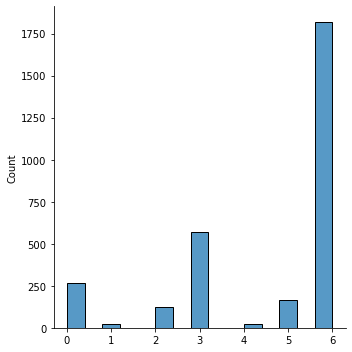

In [18]:
# Displaying Distribution of hit labels for GoEmotions Model
sns.displot(flattened_all_hit_or_miss_labels_filtered)